In [1]:
#!/usr/bin/python -W ignore::DeprecationWarning

import sys
import pickle
sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
from tester import dump_classifier_and_data
import pandas as pd
import sys
import pickle
import csv
import matplotlib.pyplot as plt

sys.path.append("../tools/")
from feature_format import featureFormat, targetFeatureSplit
#from poi_data import *
from sklearn.feature_selection import SelectKBest
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedShuffleSplit

from numpy import mean

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate

from sklearn.metrics import accuracy_score, precision_score, recall_score

#%%

In [2]:
#% ## Task 1: Select what features you'll use.
### features_list is a list of strings, each of which is a feature name.
### The first feature must be "poi".
#features_list = ['poi','salary'] # You will need to use more features

############# Task 1: Select what features you'll use.############

target_label = 'poi'


# payment_data = ['salary',
#                 'bonus',
#                 'long_term_incentive',
#                 'deferred_income',
#                 'deferral_payments',
#                 'loan_advances',
#                 'other',
#                 'expenses',                
#                 'director_fees', 
#                 'total_payments']

email_features_list = [
    'from_messages',
    'from_poi_to_this_person',
    'from_this_person_to_poi',
    'shared_receipt_with_poi',
    'to_messages',
    ]
    
financial_features_list = [
    'bonus',
    'deferral_payments',
    'deferred_income',
    'director_fees',
    'exercised_stock_options',
    'expenses',
    'loan_advances',
    'long_term_incentive',
    'other',
    'restricted_stock',
    'restricted_stock_deferred',
    'salary',
    'total_payments',
    'total_stock_value',
]



features_list = [target_label] + financial_features_list + email_features_list


In [3]:
### Load the dictionary containing the dataset
with open("final_project_dataset.pkl", "rb") as data_file:
    data_dict = pickle.load(data_file)
    
### 1.1.0 Explore csv file 
def make_csv(data_dict):
    """ generates a csv file from a data set"""
    fieldnames = ['name'] + data_dict.itervalues().next().keys()
    with open('data.csv', 'w') as csvfile:
        writer = csv.DictWriter(csvfile, fieldnames=fieldnames)
        writer.writeheader()
        for record in data_dict:
            person = data_dict[record]
            person['name'] = record
            assert set(person.keys()) == set(fieldnames)
            writer.writerow(person)

### 1.1.1 Dataset Exploration
print('# Exploratory Data Analysis #')
data_dict.keys()
print('Total number of data points: %d' % len(data_dict.keys()))
num_poi = 0
for name in data_dict.keys():
    if data_dict[name]['poi'] == True:
        num_poi += 1
print('Number of Persons of Interest: %d' % num_poi)
print('Number of people without Person of Interest label: %d' % (len(data_dict.keys()) - num_poi))



# Exploratory Data Analysis #
Total number of data points: 146
Number of Persons of Interest: 18
Number of people without Person of Interest label: 128


In [4]:
# Own activities

## Exploring the dataset through pandas.Dataframe
dataset = pd.DataFrame.from_dict(data_dict, orient='index')
dataset.head()


,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
METTS MARK,365788,807,NaN,1061827,NaN,600000,mark.metts@enron.com,NaN,NaN,585062,...,38,NaN,29,1740,1,False,NaN,702,585062,NaN
BAXTER JOHN C,267102,NaN,1295738,5634343,NaN,1200000,NaN,NaN,-1386055,10623258,...,NaN,6680544,NaN,2660303,NaN,False,1586055,NaN,3942714,NaN
ELLIOTT STEVEN,170941,NaN,NaN,211725,NaN,350000,steven.elliott@enron.com,NaN,-400729,6678735,...,NaN,4890344,NaN,12961,NaN,False,NaN,NaN,1788391,NaN
CORDES WILLIAM R,NaN,764,NaN,NaN,NaN,NaN,bill.cordes@enron.com,NaN,NaN,1038185,...,10,651850,12,NaN,0,False,NaN,58,386335,NaN
HANNON KEVIN P,243293,1045,NaN,288682,NaN,1500000,kevin.hannon@enron.com,NaN,-3117011,6391065,...,32,5538001,32,11350,21,True,1617011,1035,853064,NaN


In [5]:
dataset.describe()

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
count,146,146,146,146,146,146,146,146,146,146,...,146,146,146,146,146,146,146,146,146,146
unique,95,87,40,126,5,42,112,19,45,125,...,58,102,65,93,42,2,53,84,98,18
top,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,NaN,NaN,NaN,NaN
freq,51,60,107,21,142,64,35,128,97,20,...,60,44,60,53,60,128,80,60,36,129


In [6]:
#Converting string "NaN" to numpy.NaN
import numpy as np

for column in dataset.columns:
    dataset[column] = dataset[column].apply(lambda x: np.NaN if x == 'NaN' else x)
    
    
    
    np.NaN

## Checking the dataset information:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Index: 146 entries, METTS MARK to GLISAN JR BEN F
Data columns (total 21 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   salary                     95 non-null     float64
 1   to_messages                86 non-null     float64
 2   deferral_payments          39 non-null     float64
 3   total_payments             125 non-null    float64
 4   loan_advances              4 non-null      float64
 5   bonus                      82 non-null     float64
 6   email_address              111 non-null    object 
 7   restricted_stock_deferred  18 non-null     float64
 8   deferred_income            49 non-null     float64
 9   total_stock_value          126 non-null    float64
 10  expenses                   95 non-null     float64
 11  from_poi_to_this_person    86 non-null     float64
 12  exercised_stock_options    102 non-null    float64
 13  from_messages              86 non-

In [7]:
# aus irgendwelchen gruenden...

# for i in financial_features_list:
#    dataset[i].fillna(0,inplace=True)



#dataset.fillna(0,inplace=True)

from sklearn.impute import SimpleImputer
imp = SimpleImputer(missing_values=np.nan, strategy='mean')

# Fill in the NaN payment and stock values with zero 
for i in financial_features_list:
    dataset[i].fillna(0,inplace=True)

#dataset.fillna(0,inplace=True)


# Fill in the NaN email data with the mean of column grouped by poi/ non_poi
# imp = SimpleImputer(missing_values='NaN', strategy = 'mean', axis=0)

df_poi = dataset[dataset['poi'] == True];
df_nonpoi = dataset[dataset['poi']==False]


df_poi.loc[:, email_features_list] = imp.fit_transform(df_poi.loc[:,email_features_list]);
df_nonpoi.loc[:, email_features_list] = imp.fit_transform(df_nonpoi.loc[:,email_features_list]);
dataset = df_poi.append(df_nonpoi)



C:\Users\Varesse\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)
C:\Users\Varesse\anaconda3\lib\site-packages\pandas\core\indexing.py:1835: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value[:, i].tolist(), pi)


In [8]:


#errors = (dataset[dataset[payment_data[:-1]].sum(axis='columns') != dataset['total_payments']])
#errors





In [9]:

# Check for any more errors with the payment data
len(dataset[dataset[financial_features_list[:-1]].sum(axis='columns') != dataset['total_payments']])

# Check for any errors with the stock data
# len(dataset[dataset[stock_data[:-1]].sum(axis='columns') != dataset['total_stock_value']])


143

In [10]:
dataset

,salary,to_messages,deferral_payments,total_payments,loan_advances,bonus,email_address,restricted_stock_deferred,deferred_income,total_stock_value,...,from_poi_to_this_person,exercised_stock_options,from_messages,other,from_this_person_to_poi,poi,long_term_incentive,shared_receipt_with_poi,restricted_stock,director_fees
HANNON KEVIN P,243293.0,1045.000000,0.0,288682.0,0.0,1500000.0,kevin.hannon@enron.com,0.0,-3117011.0,6391065.0,...,32.000000,5538001.0,32.000000,11350.0,21.000000,True,1617011.0,1035.000000,853064.0,0.0
COLWELL WESLEY,288542.0,1758.000000,27610.0,1490344.0,0.0,1200000.0,wes.colwell@enron.com,0.0,-144062.0,698242.0,...,240.000000,0.0,40.000000,101740.0,11.000000,True,0.0,1132.000000,698242.0,0.0
RIEKER PAULA H,249201.0,1328.000000,214678.0,1099100.0,0.0,700000.0,paula.rieker@enron.com,0.0,-100000.0,1918887.0,...,35.000000,1635238.0,82.000000,1950.0,48.000000,True,0.0,1258.000000,283649.0,0.0
KOPPER MICHAEL J,224305.0,2417.142857,0.0,2652612.0,0.0,800000.0,michael.kopper@enron.com,0.0,0.0,985032.0,...,97.785714,0.0,300.357143,907502.0,66.714286,True,602671.0,1783.000000,985032.0,0.0
SHELBY REX,211844.0,225.000000,0.0,2003885.0,0.0,200000.0,rex.shelby@enron.com,0.0,-4167.0,2493616.0,...,13.000000,1624396.0,39.000000,1573324.0,14.000000,True,0.0,91.000000,869220.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
MARTIN AMANDA K,349487.0,1522.000000,85430.0,8407016.0,0.0,0.0,a..martin@enron.com,0.0,0.0,2070306.0,...,8.000000,2070306.0,230.000000,2818454.0,0.000000,False,5145434.0,477.000000,0.0,0.0
BUY RICHARD B,330546.0,3523.000000,649584.0,2355702.0,0.0,900000.0,rick.buy@enron.com,0.0,-694862.0,3444470.0,...,156.000000,2542813.0,1053.000000,400572.0,71.000000,False,769862.0,2333.000000,901657.0,0.0
GRAMM WENDY L,0.0,2007.111111,0.0,119292.0,0.0,0.0,NaN,0.0,0.0,0.0,...,58.500000,0.0,668.763889,0.0,36.277778,False,0.0,1058.527778,0.0,119292.0
TAYLOR MITCHELL S,265214.0,533.000000,227449.0,1092663.0,0.0,600000.0,mitchell.taylor@enron.com,0.0,0.0,3745048.0,...,0.000000,3181250.0,29.000000,0.0,0.000000,False,0.0,300.000000,563798.0,0.0


In [11]:
###1.1.2 Feature Exploration
all_features = data_dict['ALLEN PHILLIP K'].keys()
print('Each person has %d features available' %  len(all_features))
### Evaluate dataset for completeness
missing_values = {}
for feature in all_features:
    missing_values[feature] = 0
for person in data_dict.keys():
    records = 0
    for feature in all_features:
        if data_dict[person][feature] == 'NaN':
            missing_values[feature] += 1
        else:
            records += 1

### Print results of completeness analysis
print('Number of Missing Values for Each Feature:')
for feature in all_features:
    print("%s: %d" % (feature, missing_values[feature]))

Each person has 21 features available
Number of Missing Values for Each Feature:
salary: 51
to_messages: 60
deferral_payments: 107
total_payments: 21
loan_advances: 142
bonus: 64
email_address: 35
restricted_stock_deferred: 128
deferred_income: 97
total_stock_value: 20
expenses: 51
from_poi_to_this_person: 60
exercised_stock_options: 44
from_messages: 60
other: 53
from_this_person_to_poi: 60
poi: 0
long_term_incentive: 80
shared_receipt_with_poi: 60
restricted_stock: 36
director_fees: 129


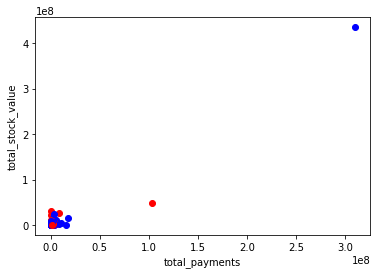

None


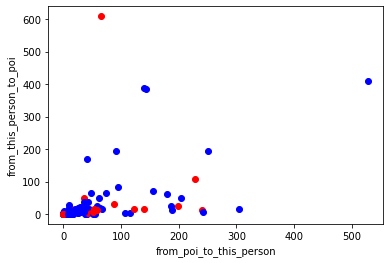

None


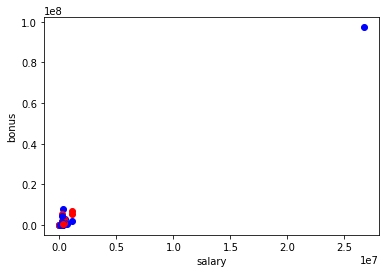

None


In [12]:
#%%
################# Task 2: Remove outliers #####################

def PlotOutlier(data_dict, feature_x, feature_y):
    """ Plot with flag = True in Red """
    data = featureFormat(data_dict, [feature_x, feature_y, 'poi'])
    for point in data:
        x = point[0]
        y = point[1]
        poi = point[2]
        if poi:
            color = 'red'
        else:
            color = 'blue'
        plt.scatter(x, y, color=color)
    plt.xlabel(feature_x)
    plt.ylabel(feature_y)
    plt.show()

# 2.1 Visualise outliers
print(PlotOutlier(data_dict, 'total_payments', 'total_stock_value'))
print(PlotOutlier(data_dict, 'from_poi_to_this_person', 'from_this_person_to_poi'))
print(PlotOutlier(data_dict, 'salary', 'bonus'))
#Remove outlier TOTAL line in pickle file.
data_dict.pop( 'TOTAL', 0 )


# 2.2 Function to remove outliers
def remove_outlier(dict_object, keys):
    """ removes list of outliers keys from dict object """
    for key in keys:
        dict_object.pop(key, 0)

outliers = ['TOTAL', 'THE TRAVEL AGENCY IN THE PARK', 'LOCKHART EUGENE E']
remove_outlier(data_dict, outliers)


In [13]:
#IQR = dataset.quantile(q=0.75) - dataset.quantile(q=0.25)
# dtype=np.float32
import numpy as np
IQR = dataset.quantile(q=0.75) - dataset.quantile(q=0.25)
#IQR = np.subtract(dataset.quantile(q=0.75), dataset.quantile(q=0.25), dtype=np.float32)

first_quartile = dataset.quantile(q=0.25)
third_quartile = dataset.quantile(q=0.75)
outliers = dataset[(dataset>(third_quartile + 1.5*IQR) ) | (dataset<(first_quartile - 1.5*IQR) )].count(axis=1)
outliers.sort_values(axis=0, ascending=False, inplace=True)
outliers.head(12)

TypeError: numpy boolean subtract, the `-` operator, is not supported, use the bitwise_xor, the `^` operator, or the logical_xor function instead.

In [ ]:
dataset
# type()

In [ ]:
outliers.loc[(dataset['poi'])==0.0]

In [ ]:

print(dataset.loc['LAY KENNETH L'])
print(dataset.loc['BELDEN TIMOTHY N'])
print(dataset.loc['RICE KENNETH D'])
print(dataset.loc['SKILLING JEFFREY K'])

In [ ]:
# Remove outliers in dataset:

dataset.drop('TOTAL',inplace=True)  #Removing the anomalous instance
dataset.drop('THE TRAVEL AGENCY IN THE PARK',inplace=True)  #Removing the anomalous instance

# Remove the outlier individuals
dataset.drop(axis=0, labels=['FREVERT MARK A', 'LAVORATO JOHN J', 'WHALLEY LAWRENCE G', 'BAXTER JOHN C'], inplace=True)


# dataset.drop('LOCKHART EUGENE E',inplace=True)  #Removing the anomalous instance

In [ ]:
# ratio of emails to an individual from a person of interest to all emails addressed to that person, 
# the second is the same but for messages to persons of interest, and the third will be the 
# ratio of email receipts shared with a person of interest to all emails addressed to that individual.

# shared_receipt_with_poi
# to_messages



# Add the new email features to the dataframe
dataset['to_poi_ratio'] = dataset['from_poi_to_this_person'] / dataset['to_messages']
dataset['from_poi_ratio'] = dataset['from_this_person_to_poi'] / dataset['from_messages']
dataset['shared_poi_ratio'] = dataset['shared_receipt_with_poi'] / dataset['to_messages']

# Create the new financial features and add to the dataframe
dataset['bonus_to_salary'] = dataset['bonus'] / dataset['salary']
dataset['bonus_to_total'] = dataset['bonus'] / dataset['total_payments']



#%%
################ Task 3: Create new feature(s) ####################

# 3.1 create new copies of dataset for grading
my_dataset = data_dict

## 3.2 add new features to dataset
def compute_fraction(poi_messages, all_messages):
    """ return fraction of messages from/to that person to/from POI"""    
    if poi_messages == 'NaN' or all_messages == 'NaN':
        return 0.
    fraction = poi_messages / all_messages
    return fraction

for name in my_dataset:
    data_point = my_dataset[name]
    from_poi_to_this_person = data_point["from_poi_to_this_person"]
    to_messages = data_point["to_messages"]
    fraction_from_poi = compute_fraction(from_poi_to_this_person, to_messages)
    data_point["fraction_from_poi"] = fraction_from_poi
    from_this_person_to_poi = data_point["from_this_person_to_poi"]
    from_messages = data_point["from_messages"]
    fraction_to_poi = compute_fraction(from_this_person_to_poi, from_messages)
    data_point["fraction_to_poi"] = fraction_to_poi

# 3.3 create new copies of feature list for grading
my_feature_list = features_list +['to_messages', 'from_poi_to_this_person', 'from_messages', 'from_this_person_to_poi','shared_receipt_with_poi', 'fraction_to_poi']

In [ ]:
# 3.4 get K-best features
num_features = 10 

# 3.5 functio using SelectKBest
def get_k_best(data_dict, features_list, k):
    """ runs scikit-learn's SelectKBest feature selection
        returns dict where keys=features, values=scores
    """
    data = featureFormat(data_dict, features_list)
    labels, features = targetFeatureSplit(data)

    k_best = SelectKBest(k=k)
    k_best.fit(features, labels)
    scores = k_best.scores_
    print(scores)
    unsorted_pairs = zip(features_list[1:], scores)
    sorted_pairs = list(reversed(sorted(unsorted_pairs, key=lambda x: x[1])))
    k_best_features = dict(sorted_pairs[:k])
    print ("{0} best features: {1}\n".format(k, k_best_features.keys(), scores))
    return k_best_features


best_features = get_k_best(my_dataset, my_feature_list, num_features)

my_feature_list = [target_label] + list(set(best_features.keys()))

In [ ]:
# 3.6 print features
print ("{0} selected features: {1}\n".format(len(my_feature_list) - 1, my_feature_list[1:]))

# 3.7 extract the features specified in features_list
data = featureFormat(my_dataset, my_feature_list,sort_keys = True)
# split into labels and features
labels, features = targetFeatureSplit(data)

# 3.8 scale features via min-max
from sklearn import preprocessing
scaler = preprocessing.MinMaxScaler()
features = scaler.fit_transform(features)


In [ ]:
# eigene aktivitäten

from sklearn.preprocessing import scale
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.cluster import KMeans
from sklearn.ensemble import AdaBoostClassifier
import tester

# Scale the dataset and send it back to a dictionary


from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(dataset[features_list])
dataset[features_list] = scaler.transform(dataset[features_list])

dataset.isnull().values.any()

dataset


In [ ]:
dataset.info()


In [ ]:

d_dataset = dataset.to_dict(orient='index')


# scaled_df = dataset.copy()
# scaled_df.iloc[:,1:] = scale(scaled_df.iloc[:,1:])
# d_dataset = scaled_df.to_dict(orient='index')

# Create and test the Gaussian Naive Bayes Classifier
# clf = GaussianNB()
# tester.dump_classifier_and_data(clf, d_dataset, features_list)
# tester.main();
# # Create and test the Decision Tree Classifier
# clf = DecisionTreeClassifier()
# tester.dump_classifier_and_data(clf, d_dataset, features_list)
# tester.main();
# # Create and test the Support Vector Classifier
# clf = SVC(kernel='linear')
# tester.dump_classifier_and_data(clf, d_dataset, features_list)
# tester.main()
# # Create and test the K Means clustering classifier
# clf = KMeans(n_clusters=2)
# tester.dump_classifier_and_data(clf, d_dataset, features_list)
# tester.main();

clf = Pipeline([
  ('select_features', SelectKBest(k=19)),
  ('classify', DecisionTreeClassifier(criterion='entropy', max_depth=None, max_features=None, min_samples_split=20))
  ])
tester.dump_classifier_and_data(clf, d_dataset, features_list)
tester.main();




In [ ]:
# ratio of emails to an individual from a person of interest to all emails addressed to that person, 
# the second is the same but for messages to persons of interest, and the third will be the ratio of
# email receipts shared with a person of interest to all emails addressed to that individual.



# shared_receipt_with_poi
# to_messages

In [ ]:
#%%
### Task 4: Try a varity of classifiers
### Please name your classifier clf for easy export below.
### Note that if you want to do PCA or other multi-stage operations,
### you'll need to use Pipelines. For more info:
### http://scikit-learn.org/stable/modules/pipeline.html

# Provided to give you a starting point. Try a variety of classifiers.

##########################Task 4: Using algorithm########################

###4.1  Gaussian Naive Bayes Classifier
from sklearn.naive_bayes import GaussianNB
g_clf = GaussianNB()

###4.2  Logistic Regression Classifier
from sklearn.linear_model import LogisticRegression

l_clf = Pipeline(steps=[
        ('scaler', StandardScaler()),
        ('classifier', LogisticRegression(C=1e-08, class_weight=None, dual=False, fit_intercept=True, intercept_scaling=1, 
max_iter=100, multi_class='ovr', penalty='l2', random_state=42, solver='liblinear', tol=0.001, verbose=0))])

###4.3  K-means Clustering
from sklearn.cluster import KMeans
k_clf = KMeans(n_clusters=2, tol=0.001)


###4.4 Support Vector Machine Classifier
from sklearn.svm import SVC
s_clf = SVC(kernel='rbf', C=1000,gamma = 0.0001,random_state = 42, class_weight = 'balanced')

###4.5 Random Forest
from sklearn.ensemble import RandomForestClassifier
rf_clf = RandomForestClassifier(max_depth = 5,max_features = 'sqrt',n_estimators = 10, random_state = 42)


###4.6 Gradient Boosting Classifier
from sklearn.ensemble  import GradientBoostingClassifier
gb_clf = GradientBoostingClassifier(loss='deviance', learning_rate=0.1, n_estimators=100,random_state = 42)


In [ ]:
###4.7 evaluate function
def evaluate_clf(clf, features, labels, num_iters=1000, test_size=0.3):
    print (clf)
    accuracy = []
    precision = []
    recall = []
    first = True
    for trial in range(num_iters):
        features_train, features_test, labels_train, labels_test =\
            train_test_split(features, labels, test_size=test_size)
        clf.fit(features_train, labels_train)
        predictions = clf.predict(features_test)
        accuracy.append(accuracy_score(labels_test, predictions))
        precision.append(precision_score(labels_test, predictions))
        recall.append(recall_score(labels_test, predictions))
        if trial % 10 == 0:
            if first:
                sys.stdout.write('\nProcessing')
            sys.stdout.write('.')
            sys.stdout.flush()
            first = False

    print ("done.\n")
    print ("precision: {}".format(mean(precision)))
    print ("recall:    {}".format(mean(recall)))
    return mean(precision), mean(recall)

In [ ]:
## 4.8 Evaluate all functions
evaluate_clf(g_clf, features, labels)
evaluate_clf(l_clf, features, labels)
evaluate_clf(k_clf, features, labels)
evaluate_clf(s_clf, features, labels)
evaluate_clf(rf_clf, features, labels)
evaluate_clf(gb_clf, features, labels)

### Select Logistic Regression as final algorithm
clf = l_clf

In [ ]:
# dump your classifier, dataset and features_list so
# anyone can run/check your results

pickle.dump(clf, open("../final_project/my_classifier.pkl", "wb"))
pickle.dump(my_dataset, open("../final_project/my_dataset.pkl", "wb"))
pickle.dump(my_feature_list, open("../final_project/my_feature_list.pkl", "wb"))

In [ ]:
#%%
### Task 5: Tune your classifier to achieve better than .42 precision and recall 
### using our testing script. Check the tester.py script in the final project
### folder for details on the evaluation method, especially the test_classifier
### function. Because of the small size of the dataset, the script uses
### stratified shuffle split cross validation. For more info: 
### http://scikit-learn.org/stable/modules/generated/sklearn.cross_validation.StratifiedShuffleSplit.html

# Example starting point. Try investigating other evaluation techniques!

features_train, features_test, labels_train, labels_test = \
    train_test_split(features, labels, test_size=0.3, random_state=42)

#%%
### Task 6: Dump your classifier, dataset, and features_list so anyone can
### check your results. You do not need to change anything below, but make sure
### that the version of poi_id.py that you submit can be run on its own and
### generates the necessary .pkl files for validating your results.

dump_classifier_and_data(clf, my_dataset, features_list)
